# Introduction

In this file I am trying to create a test suite for Multiset Estimation. I am currently testing the following:
 - False Negatives
 - False Positives
 - Count Mismatches (Length and some descriptive statistics)
 - Memory consumption in bytes

To add your Estimator, create a class with the following methods:
 - __init__(self,tokens,**kwargs) -> None # Note that, all kwargs should have defaults
 - get_frequency(self,token) -> int 
 - bytes_required(self) -> int

I have implemented Spectral Bloom Filters as SBF class and demonstrated a comparative study for different false postitve rates

# Todo
 - Implement Cuckoo Filters
 - Implement some Regression Model

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

from itertools import product
from math import ceil, log
from typing import Counter, Iterable, List
from functools import partial
from pprint import pprint

import statistics
import string

%matplotlib inline

In [54]:
class SBF:
    def __init__(self, tokens, fpr=0.01):
        n_unique_tokens = len(set(tokens))
        m, k = self.optimal_m_k(n_unique_tokens, fpr)
        k = max(k,1)
        sbf = [0] * m
        for word in tokens:
            hash_indices = self.create_hashes(token=word,
                                              hashes=k,
                                              max_length=m)
            mn = min(map(sbf.__getitem__, hash_indices))
            for idx in hash_indices:
                if sbf[idx]==mn:
                    sbf[idx]+=1
        
        self.sbf = sbf
        self.n_hashes = k
    
    def get_frequency(self,item):
        m,k = len(self.sbf), self.n_hashes
        hash_indices = self.create_hashes(token=item,
                                              hashes=k,
                                              max_length=m)
        return min(map(self.sbf.__getitem__, hash_indices))

    def bytes_required(self):
        # Assuming 1 integer = 4 bytes
        # Assuming width = 16 (2 bytes) for sbf
        return len(self.sbf)*2 + 4

    def create_hashes(self, token: str, hashes: int, max_length: int) -> list:
        return [
            self.hash_fn(key=token, seed=index) % max_length
            for index in range(hashes)
        ]
    
    def optimal_m_k(self, n: int, p: int) -> tuple:
        m = (-n * log(p) / (log(2)**2))
        k = (m / n) * log(2)
        return (ceil(m), round(k))
    
    
    
    @staticmethod
    def hash_fn(key, seed = 0):
        c1 = 0xcc9e2d51
        c2 = 0x1b873593

        length = len(key)
        h1 = seed
        roundedEnd = (length & 0xfffffffc)  # round down to 4 byte block
        for i in range(0, roundedEnd, 4):
            # little endian load order
            k1 = (ord(key[i]) & 0xff) | ((ord(key[i + 1]) & 0xff) << 8) | \
                ((ord(key[i + 2]) & 0xff) << 16) | (ord(key[i + 3]) << 24)
            k1 *= c1
            k1 = (k1 << 15) | ((k1 & 0xffffffff) >> 17) # ROTL32(k1,15)
            k1 *= c2

            h1 ^= k1
            h1 = (h1 << 13) | ((h1 & 0xffffffff) >> 19)  # ROTL32(h1,13)
            h1 = h1 * 5 + 0xe6546b64

        # tail
        k1 = 0

        val = length & 0x03
        if val == 3:
            k1 = (ord(key[roundedEnd + 2]) & 0xff) << 16
        # fallthrough
        if val in [2, 3]:
            k1 |= (ord(key[roundedEnd + 1]) & 0xff) << 8
        # fallthrough
        if val in [1, 2, 3]:
            k1 |= ord(key[roundedEnd]) & 0xff
            k1 *= c1
            k1 = (k1 << 15) | ((k1 & 0xffffffff) >> 17)  # ROTL32(k1,15)
            k1 *= c2
            h1 ^= k1

        # finalization
        h1 ^= length

        # fmix(h1)
        h1 ^= ((h1 & 0xffffffff) >> 16)
        h1 *= 0x85ebca6b
        h1 ^= ((h1 & 0xffffffff) >> 13)
        h1 *= 0xc2b2ae35
        h1 ^= ((h1 & 0xffffffff) >> 16)

        return h1 & 0xffffffff

In [62]:
class Linear_Regression:
    def __init__(self,tokens,n_params = 20):
        pass
    
    def get_frequency(self,token):
        pass

    def bytes_required(self):
        pass

In [ ]:
class Cuckoo_Filter:
    def __init__(self,tokens,fpr = 0.01):
        pass
    
    def get_frequency(self,token):
        pass

    def bytes_required(self):
        pass

In [55]:
class Multiset_Estimators_test:
    def __init__(self,estimators,tokens:list,wordlist:set):
        self.estimators = estimators
        self.tokens = tokens
        self.wordlist = wordlist
        self.results = {}
        
        for name,estimator in estimators.items():
            estimator = self.index(estimator)
            count_mismatch = self.count_mismatch(estimator)
            self.results[name] = {
                "False Negatives":self.false_negatives(estimator),
                "False Positives":self.false_positives(estimator),
                "Max Count Mismatch":max(count_mismatch),
                "Average Count Mismatch":statistics.mean(count_mismatch),
                "Stddev Count Mismatch":statistics.stdev(count_mismatch),
                "Len Count Mismatch":len(count_mismatch),
                "Bytes":estimator.bytes_required(),
            }
        
    def false_negatives(self,estimator):
        count = 0
        for token in self.tokens:
            count+=estimator.get_frequency(token)<=0
        return count
    
    def false_positives(self,estimator):
        count = 0
        for token in self.wordlist - set(self.tokens):
            count+=estimator.get_frequency(token)>0
        return count
    
    def count_mismatch(self,estimator):
        arr = []
        for k, v in Counter(self.tokens).items():
            diff = abs(v - estimator.get_frequency(k))
            arr.append(diff)
        return arr
    
    def index(self,estimator):
        return estimator(self.tokens)


In [56]:
tokens = ["a"]*3 + ["b"]*7 + ["c"]*24
wordlist = set(string.ascii_lowercase)

estimators = {
    "SBF_0.99": partial(SBF, fpr=0.99),
    "SBF_0.9": partial(SBF, fpr=0.9),
    "SBF_0.1": partial(SBF, fpr=0.1),
    "SBF_0.01": partial(SBF, fpr=0.01),
    "SBF_0.001": partial(SBF, fpr=0.001),
}
test = Multiset_Estimators_test(estimators,tokens,wordlist)

In [57]:
comparative = pd.DataFrame.from_dict(test.results,orient="index")
comparative

,False Negatives,False Positives,Max Count Mismatch,Average Count Mismatch,Stddev Count Mismatch,Len Count Mismatch,Bytes
SBF_0.99,0,23,31,22.666667,11.150486,3,6
SBF_0.9,0,23,31,22.666667,11.150486,3,6
SBF_0.1,0,0,0,0.000000,0.000000,3,34
SBF_0.01,0,0,0,0.000000,0.000000,3,62
SBF_0.001,0,0,0,0.000000,0.000000,3,92


<AxesSubplot:>

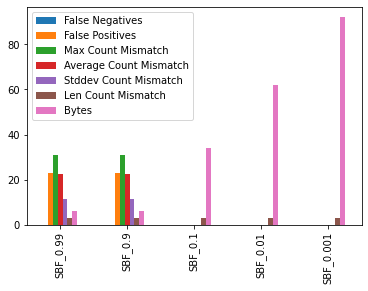

In [58]:
comparative.plot.bar()